#### The Dataset is Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India. The 4 features here are meantemp, humidity, wind_speed, meanpressure.

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [133]:
df=pd.read_csv('DailyDelhiClimateTrain.csv')
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [134]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [135]:
df.duplicated().sum()

0

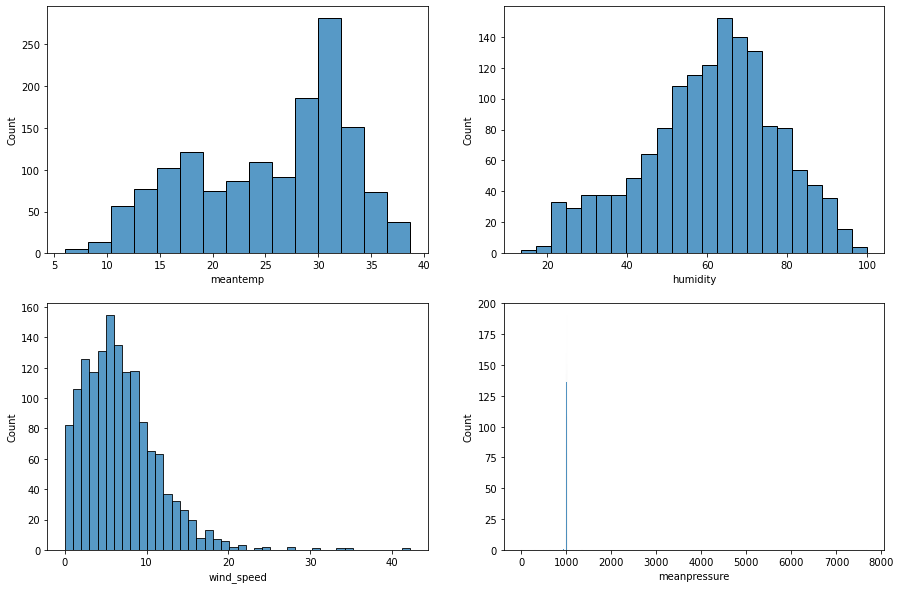

In [136]:
plt.figure(figsize=(15,10))
i=1
for col in df.iloc[:,1:5]:
    plt.subplot(2,2,i)
    sns.histplot(df[col])
    i=i+1

### i will neglect all features and work on meantemp with date 

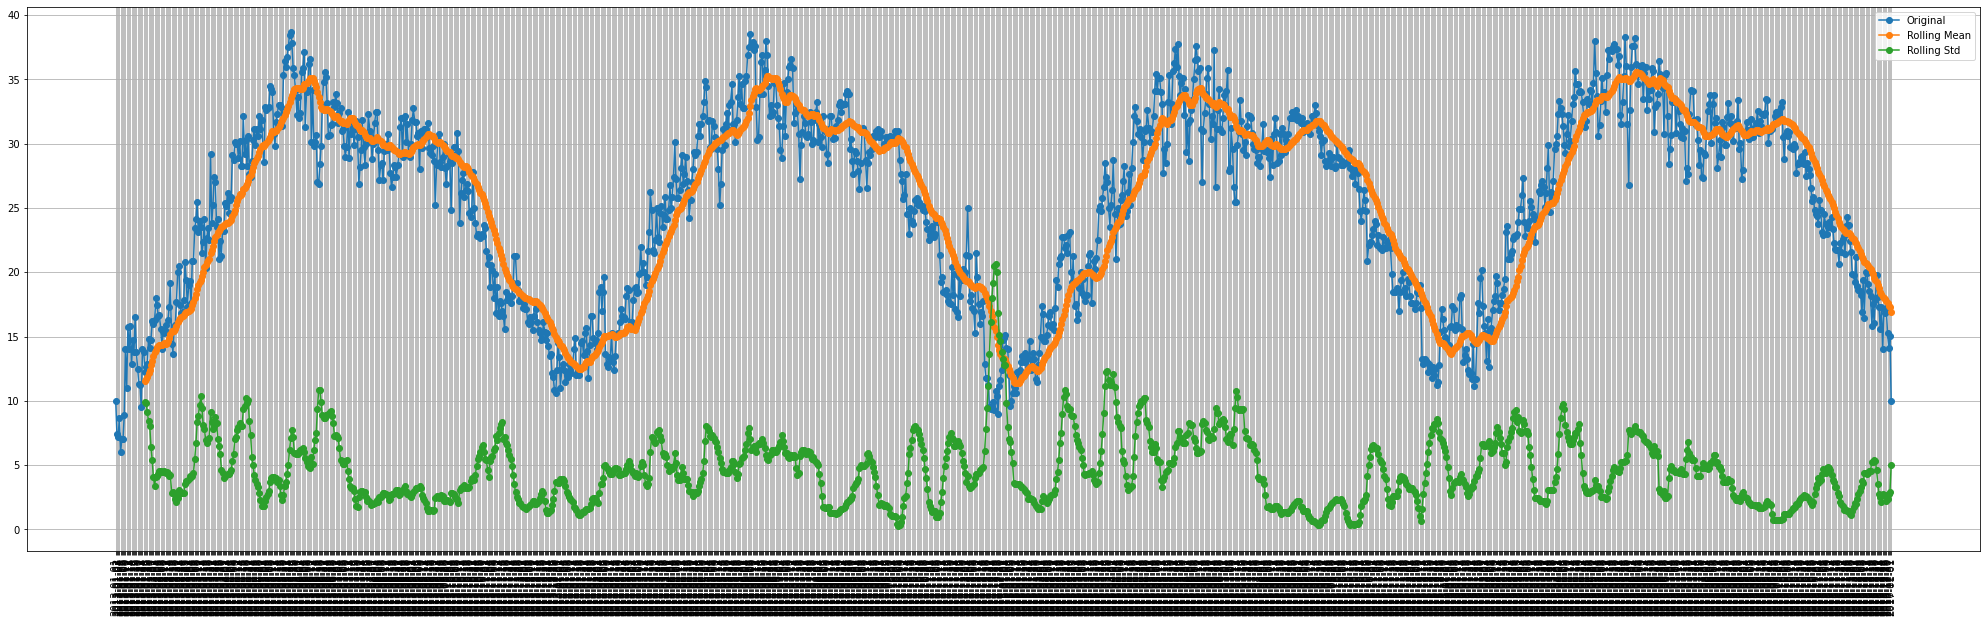

In [137]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df['date'], df['meantemp'], marker='o', label='Original')
plt.plot(df['date'], df['meantemp'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(df['date'], df['meantemp'].rolling(window=25).var(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### seems that mean and variance are non stationary 

In [138]:
df['date'] = pd.to_datetime(df['date'])

### converting date feature from object do date type

In [139]:
df.index = df["date"]
df.drop("date", axis=1, inplace=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


### make date our index column

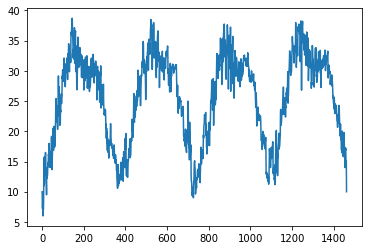

In [140]:
plt.plot([i for i in range(len(df))],df['meantemp'])

### seems that the data is stationary but lets check stationarity by adfuller

In [145]:
from statsmodels.tsa.stattools import adfuller


In [146]:
result = adfuller(df['meantemp'])


print("p-value:", result[1])


p-value: 0.2774121372301608


### p value is greater than 0.05 so we need to resampling

In [147]:
df_year_month = df.groupby(by=[df.index.year, df.index.month])['meantemp'].mean()
df_year_month

date  date
2013  1       12.074770
      2       16.867560
      3       22.814209
      4       28.895119
      5       33.776767
      6       32.480873
      7       30.663594
      8       29.547773
      9       29.840595
      10      26.129186
      11      18.811706
      12      15.179339
2014  1       13.431836
      2       15.746811
      3       21.593318
      4       28.058333
      5       31.405530
      6       34.770833
      7       32.034163
      8       31.411968
      9       29.762500
      10      26.496544
      11      20.104167
      12      14.823733
2015  1       12.708525
      2       18.791454
      3       21.547811
      4       28.002976
      5       33.352535
      6       32.737500
      7       30.409562
      8       30.330789
      9       30.650000
      10      26.865207
      11      20.754167
      12      14.989631
2016  1       15.139363
      2       19.025676
      3       25.701075
      4       32.550029
      5       34.728726
     

### resample by year and month only and draw the result  over month

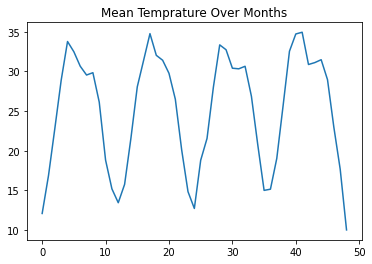

In [148]:
plt.title("Mean Temprature Over Months")
plt.plot(df_year_month.values)

In [149]:
result2 = adfuller(df_year_month.values)


print("p-value:", result2[1])


p-value: 0.7360356050589126


#### the p value increased so i will try another preprocessing way to fit arima model

In [150]:
model = ARIMA(df['meantemp'], order=(1, 0, 2))
results = model.fit()

C:\Users\kamunna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kamunna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kamunna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### The p, d, and q values  are the orders of the autoregressive (AR), differencing (I), and moving average (MA) components, respectively. 

### These values are important for determining the behavior of the ARIMA model and how it captures the patterns and dynamics in your time series data.

### it requires try and error so i tried many values and the vaues 1,0,2 works well for me 

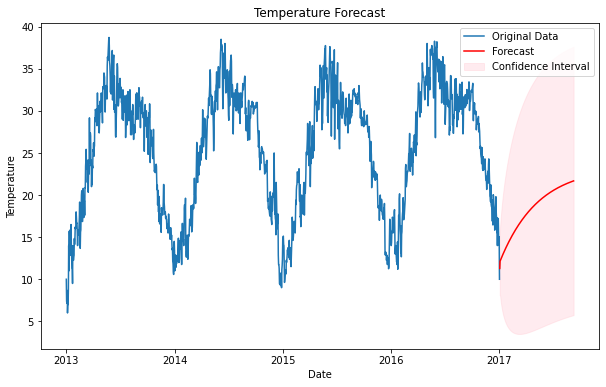

In [151]:
forecast_steps = 250 # Number of steps ahead to forecast
forecast = results.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
forecasted_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['meantemp'], label='Original Data')
plt.plot(forecasted_values.index, forecasted_values, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

#### fit the model without reaching stationary

#### try taking square root value and train the model again may be the forecasting accuracy improved and to reach stationary

C:\Users\kamunna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kamunna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kamunna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


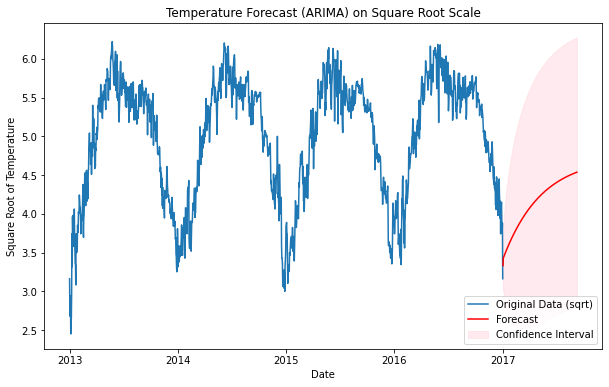

In [152]:
df['meantemp'] = np.sqrt(df['meantemp'])


# Fit ARIMA model
model = ARIMA(df['meantemp'], order=(1, 0, 2))
results = model.fit()

# Number of steps to forecast
forecast_steps = 250

# Forecast using the fitted model
forecast = results.get_forecast(steps=forecast_steps)
forecasted_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot original data, forecast, and confidence interval
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['meantemp'], label='Original Data (sqrt)')
plt.plot(forecasted_values.index, forecasted_values, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Temperature Forecast (ARIMA) on Square Root Scale')
plt.xlabel('Date')
plt.ylabel('Square Root of Temperature')
plt.legend()
plt.show()

### the forcasting is improved a little bit when we taking the square roots of tempreture feature

In [153]:
result3 = adfuller(square_root_df)


print("p-value:", result3[1])

p-value: 0.028735387866422112


### and also we reach the stationary after applied square root with p value less than 0.05

In [154]:
sc = StandardScaler()
meantemp = sc.fit_transform(df["meantemp"].values.reshape(-1,1))[:, -1]

### load test set

In [155]:
test_df = pd.read_csv("DailyDelhiClimateTest.csv")
test_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [156]:
test_df['date'] = pd.to_datetime(test_df['date'])

### same preprocessing for test data

In [157]:
test_df.index = test_df["date"]
test_df.drop("date", axis=1, inplace=True)
test_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


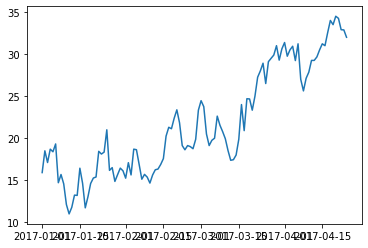

In [158]:
plt.plot(test_df["meantemp"])

In [159]:
square_root_test_df = test_df["meantemp"].values ** (1/2)

In [160]:
df["square_root_df"] = square_root_df
df.head()

,meantemp,humidity,wind_speed,meanpressure,square_root_df
date,,,,,
2013-01-01,3.162278,84.500000,0.000000,1015.666667,3.162278
2013-01-02,2.720294,92.000000,2.980000,1017.800000,2.720294
2013-01-03,2.677063,87.000000,4.633333,1018.666667,2.677063
2013-01-04,2.943920,71.333333,1.233333,1017.166667,2.943920
2013-01-05,2.449490,86.833333,3.700000,1016.500000,2.449490


In [161]:
test_df["square_root_test_df"] = square_root_test_df
test_df.head()

,meantemp,humidity,wind_speed,meanpressure,square_root_test_df
date,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,3.989116
2017-01-02,18.500000,77.222222,2.894444,1018.277778,4.301163
2017-01-03,17.111111,81.888889,4.016667,1018.333333,4.136558
2017-01-04,18.700000,70.050000,4.545000,1015.700000,4.324350
2017-01-05,18.388889,74.944444,3.300000,1014.333333,4.288227


### fit arima model 

###  lets try lstm model for better accuracy

In [162]:
model = Sequential([
    LSTM(50),
    Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")

In [163]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)[: , -1]

In [164]:
features, targets = convertToMatrix(square_root_df[:, np.newaxis], 2)
print(features.shape)
print(targets.shape)

(1460, 2, 1)
(1460,)


In [165]:
model.fit(features, targets, batch_size=1, epochs=20)

Epoch 1/20
1460/1460 [==============================] - 3s 863us/step - loss: 2.1756
Epoch 2/20
1460/1460 [==============================] - 1s 861us/step - loss: 0.0402
Epoch 3/20
1460/1460 [==============================] - 1s 837us/step - loss: 0.0431
Epoch 4/20
1460/1460 [==============================] - 1s 794us/step - loss: 0.0400
Epoch 5/20
1460/1460 [==============================] - 1s 813us/step - loss: 0.0405
Epoch 6/20
1460/1460 [==============================] - 2s 1ms/step - loss: 0.0371
Epoch 7/20
1460/1460 [==============================] - 1s 736us/step - loss: 0.0371
Epoch 8/20
1460/1460 [==============================] - 1s 734us/step - loss: 0.0359
Epoch 9/20
1460/1460 [==============================] - 1s 987us/step - loss: 0.0361
Epoch 10/20
1460/1460 [==============================] - 1s 745us/step - loss: 0.0340
Epoch 11/20
1460/1460 [==============================] - 1s 733us/step - loss: 0.0358
Epoch 12/20
1460/1460 [==============================] - 1s 744us

In [166]:
X_test, y_test = convertToMatrix(square_root_test_df[:, np.newaxis], 2)
print(X_test.shape)
print(y_test.shape)

(112, 2, 1)
(112,)


In [167]:
y_pred = model.predict(X_test)
print(y_pred.shape)

(112, 1)


In [168]:
y_pred = y_pred.reshape(112, )

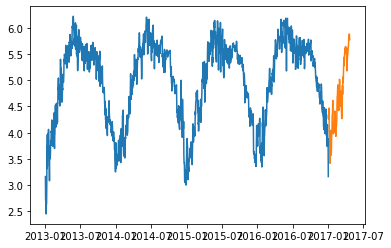

In [169]:
plt.plot(df.index, square_root_df)
plt.plot(test_df.index[:-2], y_pred)

### lstm result seems better than the arima model

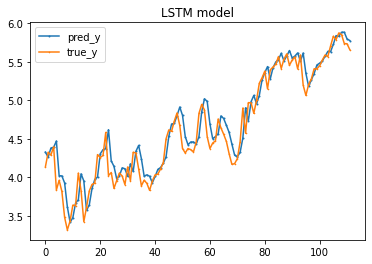

In [170]:
plt.title("LSTM model")
x=[i for i in range(len(y_test))]
plt.plot(x,y_pred,marker="o",markersize=1,label="pred_y")
plt.plot(x,y_test,marker="x",markersize=1,label="true_y")
plt.legend()
plt.show()

### this plot visualize the difference between actual y and predicted why to see how lstm model is accurate